In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Markdown, display

# Datasets
from aif360.datasets import StandardDataset

# from PhysionetDataset.py import PhysionetDataset.py
# Dataset = PhysionetDataset.py


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [26]:
#Physionet Dataset
#https://physionet.org/content/heart-failure-zigong/1.2/
np.random.seed(1)

default_mappings = {
    'label_maps': [{1.0: '1'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}



filepath = r'C:\Users\sujin\Documents\College\PhD_Project\Project/EditedData/BalancedProtectedAttributes/heart_failure_balance_NoCol.csv'
        
filepath2 = r'C:\Users\sujin\Documents\College\PhD_Project\Project/EditedData/BalancedProtectedAttributes/heart_failure_balance.csv'

df2 = pd.read_csv(filepath2)
df2.columns

class PhysionetDataset(StandardDataset):

    def __init__(self, label_name='return.to.emergency.department.within.6.months',
                 favorable_classes=[1],
                 protected_attribute_names=['gender'],
                 privileged_classes=[[1]],
                 instance_weights_name=None,
                 categorical_features=['DestinationDischarge', 'admission.ward', 'admission.way',
                                       "occupation", "discharge.department", "visit.times",
                                       "type.of.heart.failure", "NYHA.cardiac.function.classification",
                                       'Killip.grade', "ageCat", "type.II.respiratory.failure", "consciousness",
                                       "respiratory.support.", "oxygen.inhalation", "outcome.during.hospitalization"],
                 features_to_keep=[], features_to_drop=["inpatient.number"],
                 na_values=[], custom_preprocessing=None,
                 metadata=default_mappings):


        column_names = df2.columns
        try:
            df = pd.read_csv(filepath, header=None, names=column_names,
                             na_values=na_values)
            display(df)
            
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the following files:")
            print("\n\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data")
            print("\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc")
            print("\nand place them, as-is, in the folder:")
            print("\n\t{}\n".format(os.path.abspath(os.path.join(
                os.path.abspath(__file__), '..', '..', 'data', 'raw', 'german'))))
            import sys
            sys.exit(1)

        super(PhysionetDataset, self).__init__(df=df, label_name=label_name,
                                               favorable_classes=favorable_classes,
                                               protected_attribute_names=protected_attribute_names,
                                               privileged_classes=privileged_classes,
                                               instance_weights_name=instance_weights_name,
                                               categorical_features=categorical_features,
                                               features_to_keep=features_to_keep,
                                               features_to_drop=features_to_drop, na_values=na_values,
                                               custom_preprocessing=custom_preprocessing, metadata=metadata)


In [27]:
# 3.1. Load data & create splits for learning/validating/testing model¶


(dataset_orig_train, dataset_orig_val, dataset_orig_test) = PhysionetDataset().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_train.unprivileged_protected_attributes[sens_ind]]

privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_train.privileged_protected_attributes[sens_ind]]


def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes,
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


describe(dataset_orig_train, dataset_orig_val, dataset_orig_test)

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_train)

print(explainer_orig_panel19_train.disparate_impact())

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,...,glutamyltranspeptidase,glutamic.pyruvic.transaminase,alkaline.phosphatase,total.bilirubin,total.bile.acid,total.protein,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,ageCat
0,0,802586,HealthcareFacility,Others,Emergency,farmer,Others,1,0,36.7,...,10.0,11.0,70.0,3.5,4.7,68.6,0.94,1.59,1.49,"(79,89]"
1,1,800457,Home,Others,Emergency,UrbanResident,Cardiology,1,0,36.5,...,54.0,13.0,62.0,32.6,4.7,69.4,2.37,0.75,1.46,"(59,69]"
2,2,773722,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,1,36.5,...,36.0,31.0,79.0,54.6,3.7,64.5,2.68,0.75,0.77,"(69,79]"
3,3,852340,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,1,1,36.7,...,20.0,22.0,50.0,33.3,3.3,61.1,0.80,0.86,0.71,"(59,69]"
4,4,833857,HealthcareFacility,Cardiology,NonEmergency,UrbanResident,Cardiology,1,0,36.5,...,75.0,16.0,85.0,15.5,4.5,69.5,1.77,1.01,1.32,"(89,110]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,1685,822964,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,2,0,36.7,...,11.0,13.0,72.0,11.0,1.5,67.8,1.55,0.82,1.75,"(59,69]"
1686,1686,826079,Home,Others,NonEmergency,UrbanResident,Cardiology,1,1,36.1,...,31.0,30.0,67.0,23.9,15.2,56.2,2.09,0.90,0.89,"(59,69]"
1687,1687,735677,Home,GeneralWard,Emergency,farmer,GeneralWard,1,1,36.1,...,48.0,125.0,94.0,63.1,6.0,63.8,1.76,0.96,1.07,"(69,79]"
1688,1688,812475,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,1,1,36.2,...,188.0,61.0,115.0,15.5,3.2,60.7,1.49,0.90,1.20,"(69,79]"


#### Training Dataset shape

(845, 130)


#### Validation Dataset shape

(507, 130)


#### Test Dataset shape

(338, 130)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['Unnamed: 0', 'gender', 'body.temperature', 'pulse', 'respiration', 'map', 'weight', 'height', 'BMI', 'myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease', 'connective.tissue.disease', 'peptic.ulcer.disease', 'diabetes', 'moderate.to.severe.chronic.kidney.disease', 'hemiplegia', 'malignant.lymphoma', 'solid.tumor', 'liver.disease', 'AIDS', 'eye.opening', 'movement', 'fio2', 'acute.renal.failure', 'left.ventricular.end.diastolic.diameter.LV', 'creatinine.enzymatic.method', 'urea', 'uric.acid', 'glomerular.filtration.rate', 'cystatin', 'monocyte.ratio', 'lymphocyte.count', 'mean.hemoglobin.volume', 'mean.hemoglobin.concentration', 'mean.platelet.volume', 'basophil.count', 'eosinophil.count', 'hemoglobin', 'platelet.distribution.width', 'platelet.hematocrit', 'neutrophil.count', 'D.dimer', 'international.normalized.ratio', 'activated.partial.thromboplastin.time', 'thrombin.time',

In [33]:
# 3.2. Learning a Logistic Regression (LR) classifier on original data¶
# 3.2.1. Training LR model on original data

dataset = dataset_orig_train
display(dataset)
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

               instance weights   features            features  \
                                           protected attribute   
                                Unnamed: 0              gender   
instance names                                                   
547                         1.0      547.0                 1.0   
1687                        1.0     1687.0                 1.0   
126                         1.0      126.0                 1.0   
368                         1.0      368.0                 0.0   
1194                        1.0     1194.0                 0.0   
...                         ...        ...                 ...   
969                         1.0      969.0                 1.0   
445                         1.0      445.0                 1.0   
136                         1.0      136.0                 1.0   
11                          1.0       11.0                 0.0   
1422                        1.0     1422.0                 1.0   

         

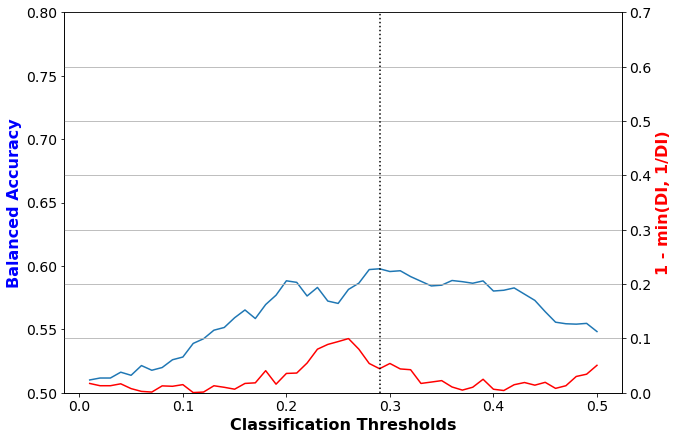

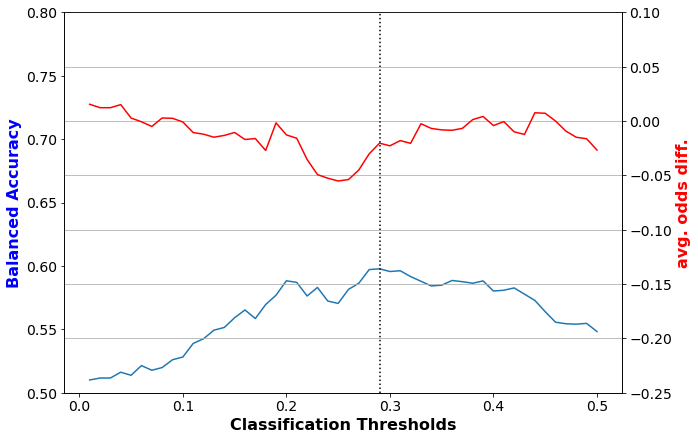

Validation Scores:
Threshold corresponding to Best balanced accuracy: 0.2900
Best balanced accuracy: 0.5978
Corresponding 1-min(DI, 1/DI) value: 0.0443
Corresponding average odds difference value: -0.0204
Corresponding statistical parity difference value: -0.0273
Corresponding equal opportunity difference value: -0.0179
Corresponding Theil index value: 0.1613


In [35]:
# 3.2.2. Validating LR model on original data¶

from collections import defaultdict


def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
            dataset, dataset_pred,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                       + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()
    
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1 / disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))


print("Validation Scores:")
describe_metrics(val_metrics, thresh_arr)

In [36]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Reweighing¶

#4.1. Transform data¶
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.2900
Best balanced accuracy: 0.5510
Corresponding 1-min(DI, 1/DI) value: 0.0389
Corresponding average odds difference value: 0.0273
Corresponding statistical parity difference value: 0.0233
Corresponding equal opportunity difference value: 0.0480
Corresponding Theil index value: 0.2197
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


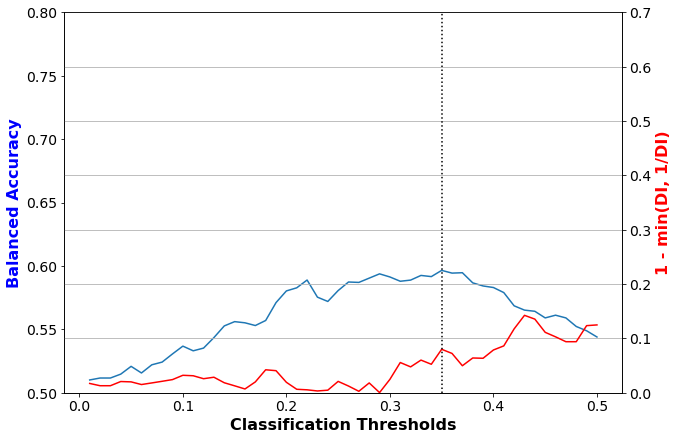

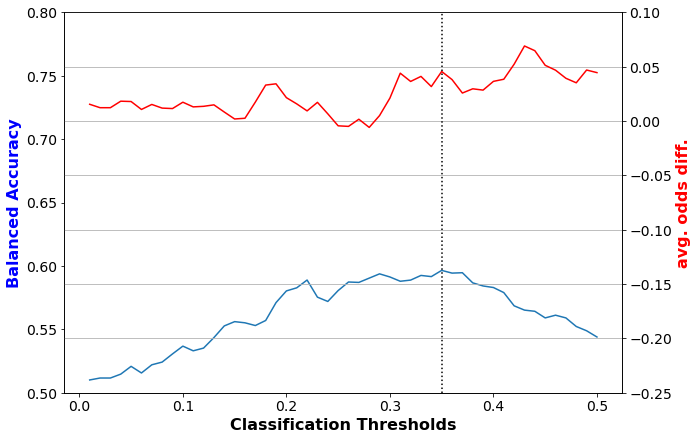

Threshold corresponding to Best balanced accuracy: 0.3500
Best balanced accuracy: 0.5965
Corresponding 1-min(DI, 1/DI) value: 0.0800
Corresponding average odds difference value: 0.0455
Corresponding statistical parity difference value: 0.0432
Corresponding equal opportunity difference value: 0.0323
Corresponding Theil index value: 0.1960


In [37]:
#4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing¶

#4.2.1. Training LR model after reweighing¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after reweighing¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [38]:
#4.2.3. Testing LR model after reweighing¶
lr_transf_metrics = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])


Threshold corresponding to Best balanced accuracy: 0.3500
Best balanced accuracy: 0.5556
Corresponding 1-min(DI, 1/DI) value: 0.1809
Corresponding average odds difference value: 0.1117
Corresponding statistical parity difference value: 0.1003
Corresponding equal opportunity difference value: 0.1793
Corresponding Theil index value: 0.2576


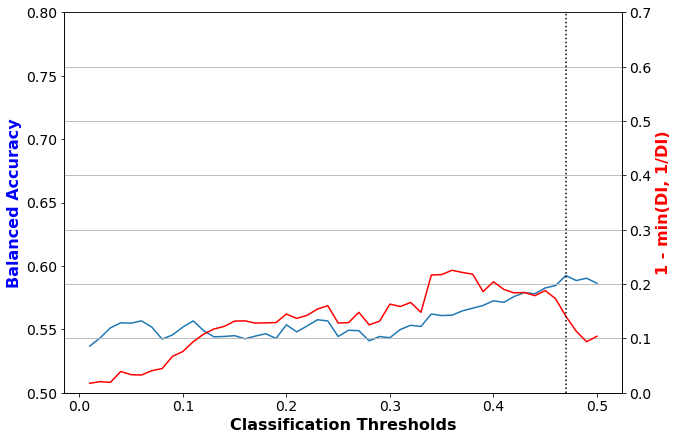

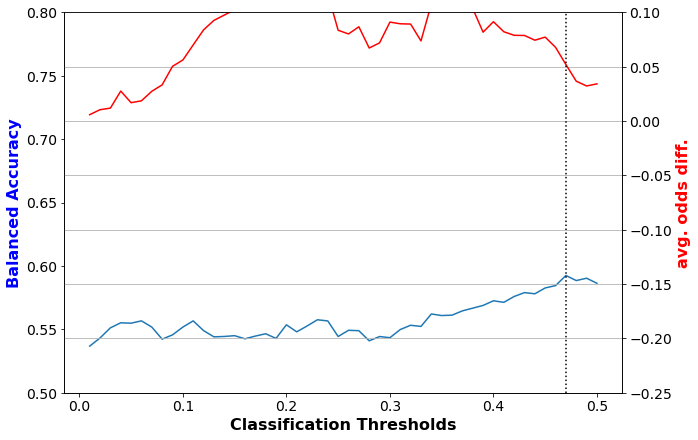

Threshold corresponding to Best balanced accuracy: 0.4700
Best balanced accuracy: 0.5925
Corresponding 1-min(DI, 1/DI) value: 0.1407
Corresponding average odds difference value: 0.0519
Corresponding statistical parity difference value: 0.0566
Corresponding equal opportunity difference value: 0.0152
Corresponding Theil index value: 0.2535


In [39]:
#5. Bias mitigation using in-processing technique - Prejudice Remover (PR)¶

#5.1.1. Training a PR model
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig = model.fit(dataset)

#5.1.2. Validating PR model¶

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [40]:
#5.1.3. Testing PR model¶

dataset = dataset_orig_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.4700
Best balanced accuracy: 0.5688
Corresponding 1-min(DI, 1/DI) value: 0.0728
Corresponding average odds difference value: 0.0307
Corresponding statistical parity difference value: 0.0274
Corresponding equal opportunity difference value: 0.0455
Corresponding Theil index value: 0.3186


In [41]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.550984,0.027255,1.040426,0.023313,0.048044,0.219688
Reweighing,Logistic Regression,0.555619,0.111748,1.220927,0.100298,0.179273,0.257647
Prejudice Remover,,0.568770,0.030658,1.078496,0.027450,0.045464,0.318600


In [42]:
#Disparate Impact Remover

from aif360.algorithms.preprocessing import DisparateImpactRemover


In [43]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Disparate Impact Remover¶

#4.1. Transform data¶


di = DisparateImpactRemover(repair_level=1.0)
dataset_transf_train = di.fit_transform(dataset_orig_train)
dataset_transf_test = di.fit_transform(dataset_orig_test)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.2900
Best balanced accuracy: 0.5510
Corresponding 1-min(DI, 1/DI) value: 0.0389
Corresponding average odds difference value: 0.0273
Corresponding statistical parity difference value: 0.0233
Corresponding equal opportunity difference value: 0.0480
Corresponding Theil index value: 0.2197
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9065805988882912


Threshold corresponding to Best balanced accuracy: 0.3700
Best balanced accuracy: 0.6073
Corresponding 1-min(DI, 1/DI) value: 0.0277
Corresponding average odds difference value: 0.0135
Corresponding statistical parity difference value: 0.0141
Corresponding equal opportunity difference value: -0.0123
Corresponding Theil index value: 0.1954


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


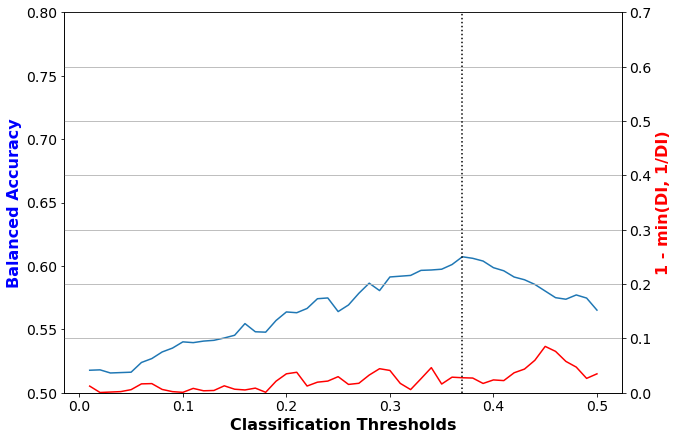

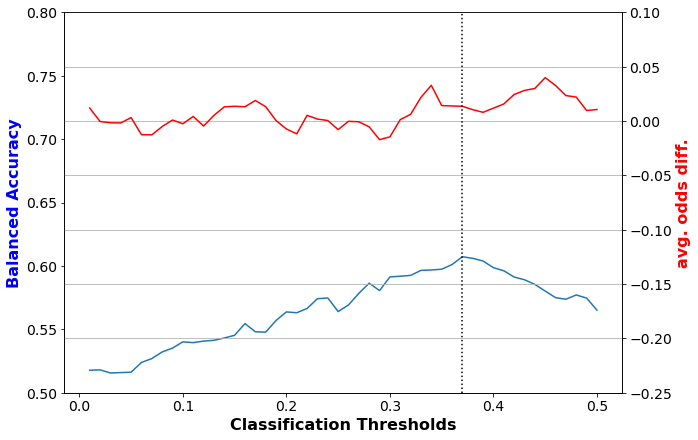

In [44]:
#4.2.1. Training LR model after Disparate Impact Remover¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after Disdparate impact Remover¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

In [45]:
#Test LR DIR Model

lr_metrics_DIR = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_metrics_DIR, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.3700
Best balanced accuracy: 0.5521
Corresponding 1-min(DI, 1/DI) value: 0.1320
Corresponding average odds difference value: 0.0728
Corresponding statistical parity difference value: 0.0709
Corresponding equal opportunity difference value: 0.0810
Corresponding Theil index value: 0.2613


In [46]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.550984,0.027255,1.040426,0.023313,0.048044,0.219688
Reweighing,Logistic Regression,0.555619,0.111748,1.220927,0.100298,0.179273,0.257647
Prejudice Remover,,0.568770,0.030658,1.078496,0.027450,0.045464,0.318600
Disparate Impact Remover,Logistic Regression,0.552098,0.072832,1.152030,0.070885,0.081001,0.261305


In [47]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.037952
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.006170


In [48]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.037952
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.006170


In [49]:
#Learn plan classifier without debiasing
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

plain_model.fit(dataset_orig_train)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.736790
epoch 1; iter: 0; batch classifier loss: 0.647447
epoch 2; iter: 0; batch classifier loss: 0.641155
epoch 3; iter: 0; batch classifier loss: 0.685148
epoch 4; iter: 0; batch classifier loss: 0.616053
epoch 5; iter: 0; batch classifier loss: 0.648198
epoch 6; iter: 0; batch classifier loss: 0.610220
epoch 7; iter: 0; batch classifier loss: 0.643082
epoch 8; iter: 0; batch classifier loss: 0.587199
epoch 9; iter: 0; batch classifier loss: 0.568677
epoch 10; iter: 0; batch classifier loss: 0.617542
epoch 11; iter: 0; batch classifier loss: 0.617771
epoch 12; iter: 0; batch classifier loss: 0.593089
epoch 13; iter: 0; batch classifier loss: 0.636252
epoch 14; iter: 0; batch classifier loss: 0.634395
epoch 15; iter: 0; batch classifier loss: 0.552686
epoch 16; iter: 0; batch classifier loss: 0.586823
epoch 17; iter: 0; batch classifier loss: 0.587258
epoch 18; iter: 0; batch classifier loss: 0.617292
epoch 19; iter: 0; batch classifier loss:

In [50]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [51]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Statisticsal parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

metrics_AD = defaultdict(list,
            {'bal_acc': [bal_acc_nodebiasing_test],
             'avg_odds_diff': [classified_metric_nodebiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_nodebiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_nodebiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_nodebiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_nodebiasing_test.theil_index()]})


#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.064103
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.042629


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.609467
Test set: Balanced classification accuracy = 0.574016
Test set: Average odds difference = -0.038713
Test set: Disparate impact = 0.852158
Test set: Statisticsal parity difference = -0.042629
Test set: Equal opportunity difference = -0.019853
Test set: Theil_index = 0.360941


In [52]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR, metrics_AD]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"] + ["Adversarial Debias"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"] + ["No Debias"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.550984,0.027255,1.040426,0.023313,0.048044,0.219688
Reweighing,Logistic Regression,0.555619,0.111748,1.220927,0.100298,0.179273,0.257647
Prejudice Remover,,0.568770,0.030658,1.078496,0.027450,0.045464,0.318600
Disparate Impact Remover,Logistic Regression,0.552098,0.072832,1.152030,0.070885,0.081001,0.261305
Adversarial Debias,No Debias,0.574016,-0.038713,0.852158,-0.042629,-0.019853,0.360941


In [53]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_train)


epoch 0; iter: 0; batch classifier loss: 0.673132; batch adversarial loss: 0.684342
epoch 1; iter: 0; batch classifier loss: 0.637730; batch adversarial loss: 0.692760
epoch 2; iter: 0; batch classifier loss: 0.648050; batch adversarial loss: 0.700157
epoch 3; iter: 0; batch classifier loss: 0.655579; batch adversarial loss: 0.705685
epoch 4; iter: 0; batch classifier loss: 0.630085; batch adversarial loss: 0.694600
epoch 5; iter: 0; batch classifier loss: 0.631157; batch adversarial loss: 0.703337
epoch 6; iter: 0; batch classifier loss: 0.590707; batch adversarial loss: 0.695378
epoch 7; iter: 0; batch classifier loss: 0.634821; batch adversarial loss: 0.704358
epoch 8; iter: 0; batch classifier loss: 0.590032; batch adversarial loss: 0.711459
epoch 9; iter: 0; batch classifier loss: 0.599006; batch adversarial loss: 0.688251
epoch 10; iter: 0; batch classifier loss: 0.627072; batch adversarial loss: 0.712395
epoch 11; iter: 0; batch classifier loss: 0.599518; batch adversarial loss:

In [54]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [55]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())





display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

metrics_AD2 = defaultdict(list,
            {'bal_acc': [bal_acc_debiasing_test],
             'avg_odds_diff': [classified_metric_debiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_debiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_debiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_debiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_debiasing_test.theil_index()]})

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.064103
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.042629


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.000219
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.101911


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.609467
Test set: Balanced classification accuracy = 0.574016
Test set: Disparate impact = 0.852158
Test set: Equal opportunity difference = -0.019853
Test set: Average odds difference = -0.038713
Test set: Theil_index = 0.360941


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.582840
Test set: Balanced classification accuracy = 0.554937
Test set: Disparate impact = 1.386312
Test set: Equal opportunity difference = 0.119516
Test set: Average odds difference = 0.104918
Test set: Theil_index = 0.351800


In [56]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            lr_metrics_DIR,pr_orig_metrics, metrics_AD, metrics_AD2]
debias = pd.Series(['None'] + ['Reweighing']
                 + ["Disparate Impact Remover"] + ['Prejudice Remover']+ ["Adversarial Debias"]*2,
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*4 + ["GD(No Debias)"] +["GD(Debased)"],
                name='Classifier')
final_df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])
final_df

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.550984,0.027255,1.040426,0.023313,0.048044,0.219688
Reweighing,Logistic Regression,0.555619,0.111748,1.220927,0.100298,0.179273,0.257647
Disparate Impact Remover,Logistic Regression,0.552098,0.072832,1.152030,0.070885,0.081001,0.261305
Prejudice Remover,Logistic Regression,0.568770,0.030658,1.078496,0.027450,0.045464,0.318600
Adversarial Debias,GD(No Debias),0.574016,-0.038713,0.852158,-0.042629,-0.019853,0.360941
Adversarial Debias,GD(Debased),0.554937,0.104918,1.386312,0.101911,0.119516,0.351800


In [59]:
final_df.to_pickle("EditedData/BalancedProtectedAttributes/HeartFailure_Results_Bal_P_Pickle")
pickle = pd.read_pickle("EditedData/BalancedProtectedAttributes/HeartFailure_Results_Bal_P_Pickle")
pickle

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.550984,0.027255,1.040426,0.023313,0.048044,0.219688
Reweighing,Logistic Regression,0.555619,0.111748,1.220927,0.100298,0.179273,0.257647
Disparate Impact Remover,Logistic Regression,0.552098,0.072832,1.152030,0.070885,0.081001,0.261305
Prejudice Remover,Logistic Regression,0.568770,0.030658,1.078496,0.027450,0.045464,0.318600
Adversarial Debias,GD(No Debias),0.574016,-0.038713,0.852158,-0.042629,-0.019853,0.360941
Adversarial Debias,GD(Debased),0.554937,0.104918,1.386312,0.101911,0.119516,0.351800
